In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=4ef89535242c003dd1694de71e07591fdb91f01ee29dd025cc20ff8f9d9292e6
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np 
import pandas as pd 

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

import xgboost as xgb 

from lifelines import KaplanMeierFitter

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt

import os
import random
import pickle

In [3]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

In [4]:
class DataTransformation:
    """
    A class for transforming and preprocessing data for machine learning models.
    """
    def __init__(self, data_train: pd.DataFrame, data_test: pd.DataFrame):
        """
        Initializes the DataTransformation class.

        Args:
            data_train (pd.DataFrame): The training data.
            data_test (pd.DataFrame): The testing data.
        """
        self.data_train = data_train.copy()
        self.data_test = data_test.copy()
    
    def numeric_transform(self):
        """
        Transforms numeric columns by filling missing values with the median,
        casting to appropriate data types, and applying StandardScaler.
        """
        _num_col = self.data_train.select_dtypes(include=['int', 'float']).columns
        
        for col in _num_col:
            m_v_1 = self.data_train[col].median()

            self.data_train[col] = self.data_train[col].fillna(m_v_1)
            self.data_test[col] = self.data_test[col].fillna(m_v_1)

            if self.data_train[col].dtype == 'int64':
                self.data_train[col] = self.data_train[col].astype('int32')
                self.data_test[col] = self.data_test[col].astype('int32')
            else:
                self.data_train[col] = self.data_train[col].astype('float32')
                self.data_test[col] = self.data_test[col].astype('float32')
        
        scaler = StandardScaler()
        self.data_train[_num_col] = scaler.fit_transform(self.data_train[_num_col])
        self.data_test[_num_col] = scaler.fit_transform(self.data_test[_num_col])

    def categoric_transform(self):
        """
        Transforms categorical columns by filling missing values with 'Missing',
        applying LabelEncoder.
        """
        _cat_col = self.data_train.select_dtypes(include=['object', 'category']).columns

        for col in _cat_col:
            le = LabelEncoder()
            self.data_train[col] = self.data_train[col].fillna('Missing')
            self.data_test[col] = self.data_test[col].fillna('Missing')
            self.data_train[col] = le.fit_transform(self.data_train[col])
            self.data_test[col] = le.transform(self.data_test[col])

    
    def _transformation_values(self):
        """
        Applies numeric and categorical transformations to the data.

        Returns:
            tuple: A tuple containing the transformed training data,
                   transformed testing data.
        """
        self.numeric_transform()
        self.categoric_transform()
        
        return (
            self.data_train.copy(),
            self.data_test.copy()
        )

In [5]:
class XGBoostModel:
    def __init__(self, objective='reg:squarederror', eval_metric='mae', n_trials=100):
        """
        XGBoost model class.

        Args:
            objective (str): XGBoost objective function. Default: 'reg:squarederror'.
            eval_metric (str): Evaluation metric. Default: 'mae'.
            n_trials (int): Number of trials for Optuna optimization. Default: 100.
        """
        self.objective = objective
        self.eval_metric = eval_metric
        self.n_trials = n_trials
        self.best_params = None
        self.model = None
        self.history = None  
        self.best_iteration = None

    def objective_function(self, trial, X_train, y_train, X_val, y_val):
        """
        Objective function for Optuna optimization.

        Args:
            trial (optuna.trial.Trial): Optuna trial.
            X_train (pd.DataFrame): Training data features.
            y_train (pd.Series): Training data target variable.
            X_val (pd.DataFrame): Validation data features.
            y_val (pd.Series): Validation data target variable.

        Returns:
            float: Evaluation metric score on the validation data.
        """
        params = {
            'objective': self.objective,
            'eval_metric': self.eval_metric,
            'device': 'cuda',
            'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'seed': 42
        }

        if params['booster'] in ['gbtree', 'dart']:
            params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)

        preds = model.predict(X_val)

        if self.eval_metric == 'mae':
            score = mean_absolute_error(y_val, preds)
        elif self.eval_metric == 'rmse':
            score = np.sqrt(mean_squared_error(y_val, preds))
        elif self.eval_metric == 'auc':  
            score = accuracy_score(y_val, np.round(preds))  
        else:
            raise ValueError(f"Unknown evaluation metric: {self.eval_metric}")

        return score

    def optimize_hyperparameters(self, X_train, y_train, X_val, y_val):
        """
        Optimizes hyperparameters using Optuna.

        Args:
            X_train (pd.DataFrame): Training data features.
            y_train (pd.Series): Training data target variable.
            X_val (pd.DataFrame): Validation data features.
            y_val (pd.Series): Validation data target variable.
        """
        study = optuna.create_study(direction='minimize')  
        study.optimize(lambda trial: self.objective_function(trial, X_train, y_train, X_val, y_val),
                       n_trials=self.n_trials)

        self.best_params = study.best_params
        print(f"Best parameters: {self.best_params}")

    def train(self, X_train, y_train, X_val=None, y_val=None):
        """
        Trains the XGBoost model with manual early stopping.

        Args:
            X_train (pd.DataFrame): Training data features.
            y_train (pd.Series): Training data target variable.
            X_val (pd.DataFrame, optional): Validation data features. Default: None.
            y_val (pd.Series, optional): Validation data target variable. Default: None.
        """
        if self.best_params is None:
            raise ValueError("You must optimize hyperparameters first.")

        params = self.best_params.copy()
        params['objective'] = self.objective
        params['eval_metric'] = self.eval_metric
        params['seed'] = 42

        self.model = xgb.XGBRegressor(**params)

        if X_val is not None and y_val is not None:
            eval_set = [(X_val, y_val)]

            N_EARLY_STOPPING = 50
            best_score = float('inf') if self.eval_metric in ['mae', 'rmse'] else float('-inf')
            best_iteration = 0
            best_model = None

            self.model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
            self.history = self.model.evals_result()

            print("Structure of self.history:", self.history.keys())

            if 'validation_0' in self.history and self.eval_metric in self.history['validation_0']:
                metric_key = self.eval_metric
                validation_key = 'validation_0'
            elif 0 in self.history and self.eval_metric in self.history[0]:
                metric_key = self.eval_metric
                validation_key = 0
            else:
                raise ValueError("Could not determine the structure of the training history.")

            for i in range(len(self.history[validation_key][metric_key])):
                score = self.history[validation_key][metric_key][i]

                if self.eval_metric in ['mae', 'rmse']:
                    if score < best_score:
                        best_score = score
                        best_iteration = i
                        best_model = pickle.loads(pickle.dumps(self.model))  
                    elif i - best_iteration > N_EARLY_STOPPING:
                        print(f"Early stopping at iteration {i}!")
                        break
                else:  
                    if score > best_score:
                        best_score = score
                        best_iteration = i
                        best_model = pickle.loads(pickle.dumps(self.model))  
                    elif i - best_iteration > N_EARLY_STOPPING:
                        print(f"Early stopping at iteration {i}!")
                        break

            if best_model is not None:
                self.model = best_model
                self.best_iteration = best_iteration
                print(f"Best model from iteration {best_iteration} used.")
            else:
                self.best_iteration = len(self.history[validation_key][metric_key]) - 1
                print("No improvement during training, using the last model.")
        else:
            self.model.fit(X_train, y_train)
            self.history = None  
            self.best_iteration = None

    def plot_training_history(self):
        """
        Visualizes the training history.
        """
        if self.history is None:
            print("Training history is not available. Please train with validation data.")
            return

        if 'validation_0' in self.history and self.eval_metric in self.history['validation_0']:
            metric_key = self.eval_metric
            validation_key = 'validation_0'
        elif 0 in self.history and self.eval_metric in self.history[0]:
            metric_key = self.eval_metric
            validation_key = 0
        else:
            print("Could not determine the structure of the training history for plotting.")
            return

        plt.figure(figsize=(10, 6))
        plt.plot(self.history[validation_key][metric_key], label=f'Validation ({self.eval_metric})')
        if self.best_iteration is not None:
            plt.axvline(self.best_iteration, color='red', linestyle='--', label=f'Best Iteration ({self.best_iteration})')
        plt.xlabel('Training Round')
        plt.ylabel(self.eval_metric.upper())
        plt.title(f'XGBoost Training History ({self.eval_metric})')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, X):
        """
        Makes predictions using the model.

        Args:
            X (pd.DataFrame): Data features to predict.

        Returns:
            np.ndarray: Prediction results.
        """
        if self.model is None:
            raise ValueError("You must train the model first.")
        return self.model.predict(X)

    def save_model(self, filepath):
        """
        Saves the model to the specified file.

        Args:
            filepath (str): File path to save the model.
        """
        with open(filepath, 'wb') as f:
            pickle.dump(self.model, f)
        print(f"Model saved to: {filepath}")

    def load_model(self, filepath):
        """
        Loads the model from the specified file.

        Args:
            filepath (str): File path to load the model from.
        """
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found: {filepath}")

        with open(filepath, 'rb') as f:
            self.model = pickle.load(f)
        print(f"Model loaded from: {filepath}")

    def evaluate(self, X_test, y_test):
        """
        Evaluates the model on the test data.

        Args:
            X_test (pd.DataFrame): Test data features.
            y_test (pd.Series): Test data target variable.

        Returns:
            float: Evaluation metric score on the test data.
        """
        if self.model is None:
            raise ValueError("You must train the model first.")

        preds = self.predict(X_test)
        if self.eval_metric == 'mae':
            score = mean_absolute_error(y_test, preds)
        elif self.eval_metric == 'rmse':
            score = np.sqrt(mean_squared_error(y_test, preds))
        elif self.eval_metric == 'auc':  # Example AUC, adjust as needed
            score = accuracy_score(y_test, np.round(preds))  # Convert to binary for AUC
        else:
            raise ValueError(f"Unknown evaluation metric: {self.eval_metric}")
        print(f"Test data {self.eval_metric}: {score}")
        return score

In [6]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(42)

In [7]:
df_train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
df_test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

df_tr_y_time = df_train[['efs', 'efs_time']]
df_train = df_train.drop(columns=['ID','efs','efs_time'])

In [8]:
df_tr_y_time['target'] = transform_survival_probability(df_tr_y_time, time_col='efs_time', event_col='efs')
tr_y = df_tr_y_time.copy().drop(columns=['efs', 'efs_time'])

In [9]:
TF = DataTransformation(df_train, df_test)
data_train, data_test = TF._transformation_values()

In [10]:
X_train, X_other, y_train, y_other = train_test_split(data_train, tr_y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.25, random_state=42)

In [11]:
%%time

model_rmse = XGBoostModel(objective='reg:squarederror', eval_metric='rmse', n_trials=50)
model_rmse.optimize_hyperparameters(X_train, y_train, X_val, y_val)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:13:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bylevel", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:13:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:14:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_byleve

Best parameters: {'booster': 'dart', 'lambda': 0.1538300956869773, 'alpha': 1.4887837016666831e-05, 'learning_rate': 0.09268770983220953, 'max_depth': 3, 'n_estimators': 591, 'subsample': 0.9427149986898793, 'colsample_bytree': 0.8123279882586707, 'colsample_bylevel': 0.9632016749763558, 'min_child_weight': 2, 'gamma': 6.292989187378552e-07, 'grow_policy': 'depthwise'}
CPU times: user 34min 31s, sys: 1.54 s, total: 34min 32s
Wall time: 33min 13s


Structure of self.history: dict_keys(['validation_0'])
Best model from iteration 557 used.


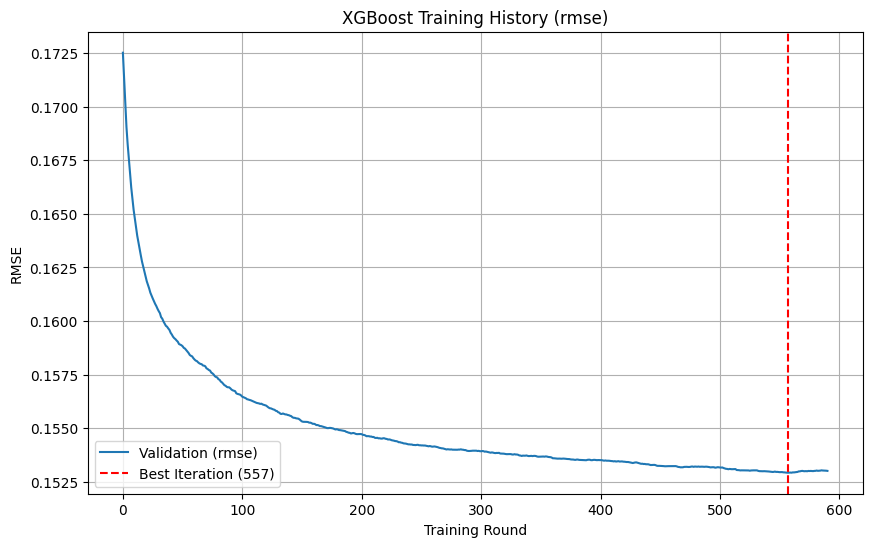

Test data rmse: 0.16176306588083278
Model saved to: /kaggle/working/xgboost_model_rmse.pkl


In [12]:
model_rmse.train(X_train, y_train, X_val, y_val)
model_rmse.plot_training_history()
model_rmse.evaluate(X_test, y_test)
model_rmse.save_model('/kaggle/working/xgboost_model_rmse.pkl')

In [13]:
data_test_id = data_test['ID']
data_test = data_test.drop(columns=['ID'])

In [14]:
loaded_model = XGBoostModel() 
loaded_model.load_model('/kaggle/working/xgboost_model_rmse.pkl')
predictions = loaded_model.predict(data_test)
print("Predictions:",predictions) 

Model loaded from: /kaggle/working/xgboost_model_rmse.pkl
Predictions: [0.54832447 0.65658593 0.5233224 ]


In [15]:
output = pd.DataFrame({
    'ID': data_test_id, 
    'prediction': predictions
})

output

,ID,prediction
0,28800,0.548324
1,28801,0.656586
2,28802,0.523322


In [16]:
output.to_csv('submission.csv', index=False)